In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

project_path = "/content/drive/MyDrive/Colab Notebooks"
os.chdir(project_path)

print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks


In [3]:
import pandas as pd
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import torch
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# This downloads the pre-trained model (happens once)
# FinBERT = BERT fine-tuned on financial text
sentiment_analyzer = pipeline(
    "sentiment-analysis", # task type
    model="ProsusAI/finbert" # specific financial sentiment model
)

# Test it works
test = sentiment_analyzer("Tesla reports strong Q4 earnings")
print(test)
# Output: [{'label': 'positive', 'score': 0.95}]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.9512251019477844}]


In [ ]:
import torch
# check running on GPU
torch.cuda.is_available()

True

In [ ]:
# Load news data
news_df = pd.read_csv("data_storage/tesla_news_cleaned.csv")

# Convert date column to datetime
news_df['date'] = pd.to_datetime(news_df['date'])

# Make sure we're on GPU
device = 0 if torch.cuda.is_available() else -1

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    device=device
)


# Prepare text
texts = (
    news_df['headline']
    .fillna('')
    .str.slice(0, 512)   # limit to model max
    .tolist()
)

# Run batched inference
with torch.no_grad(): # prevents stalls, slight speed boost + lower memory usage
    results = sentiment_analyzer(
        texts,
        batch_size=32,
        truncation=True
    )



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
def convert_result(result):
    if result['label'] == 'positive':
        return result['score']
    elif result['label'] == 'negative':
        return -result['score']
    else:
        return 0.0

# Convert results to numeric sentiment scores
news_df['sentiment_score'] = [convert_result(r) for r in results]

# Add flags for positive, negative, neutral
news_df['is_positive'] = news_df['sentiment_score'] > 0
news_df['is_negative'] = news_df['sentiment_score'] < 0
news_df['is_neutral']  = news_df['sentiment_score'] == 0

# Save the detailed news_df
news_df.to_csv("data_storage/daily_news_with_sentiment_scores.csv", index=False)
print(news_df.head())

# Aggregate by date
daily_sentiment = (
    news_df
    .groupby(news_df['date'].dt.date)
    .agg(
        avg_sentiment=('sentiment_score', 'mean'),
        median_sentiment=('sentiment_score', 'median'),
        min_sentiment=('sentiment_score', 'min'),
        max_sentiment=('sentiment_score', 'max'),
        article_count=('sentiment_score', 'count'),
        pos_ratio=('is_positive', 'mean'),   # fraction of positive articles
        neg_ratio=('is_negative', 'mean'),   # fraction of negative articles
        neutral_ratio=('is_neutral', 'mean') # fraction of neutral articles
    )
    .reset_index()
)

print(daily_sentiment.head())

# Save aggregated daily sentiment
daily_sentiment.to_csv("data_storage/daily_news_sentiment.csv", index=False)
print(f"Processed {len(news_df)} articles")


                 date                                           headline  \
0 2024-01-01 08:00:00  You Can Now Buy A Tesla Model 3 Performance Fo...   
1 2024-01-01 08:00:00  Tesla lashes Reuters for 'wildly misleading' s...   
2 2024-01-01 08:00:00  Tesla Model 3 Battery Size, Voltage, And Charg...   
3 2024-01-01 08:00:00  The Tesla Cybertruck Has Made 0 To 60 MPH Time...   
4 2024-01-01 08:00:00  Tesla's EV Business Faces 'Challenges' In 2024...   

                      source  sentiment_score  is_positive  is_negative  \
0                  InsideEVs         0.000000        False        False   
1                  CarExpert        -0.940141        False         True   
2                  Top Speed         0.000000        False        False   
3                    CarBuzz         0.000000        False        False   
4  Investor's Business Daily         0.000000        False        False   

   is_neutral  
0        True  
1       False  
2        True  
3        True  
4        Tru

In [ ]:
# Total number of articles
total_articles = len(news_df)

# Total number of unique days
unique_days = news_df['date'].dt.date.nunique()

# Average, min, max articles per day
avg_articles_per_day = daily_sentiment['article_count'].mean()
min_articles_per_day = daily_sentiment['article_count'].min()
max_articles_per_day = daily_sentiment['article_count'].max()

print(f"Total articles: {total_articles}")
print(f"Unique days: {unique_days}")
print(f"Articles per day - avg: {avg_articles_per_day:.2f}, min: {min_articles_per_day}, max: {max_articles_per_day}")


Total articles: 25398
Unique days: 732
Articles per day - avg: 34.70, min: 3, max: 92


In [ ]:
import re
from datetime import datetime
import numpy as np
import glob

# Find all earnings call files
earnings_files = glob.glob("earnings_calls/*.rtf")

earnings_sentiment = []

for file_path in earnings_files:
    filename = os.path.basename(file_path)

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()

    # -----------------------------
    # Extract date from text
    # -----------------------------
    # Look for patterns like "Apr 23, 2024"
    date_match = re.search(r'\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2},\s+\d{4}\b', text)
    if date_match:
        call_date = datetime.strptime(date_match.group(0), "%b %d, %Y").date()
    else:
        call_date = None  # fallback if not found

    # -----------------------------
    # Split into chunks
    # -----------------------------
    chunk_size = 512
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

    # -----------------------------
    # Run batched inference
    # -----------------------------
    with torch.no_grad():
        results = sentiment_analyzer(
            chunks,
            batch_size=32,
            truncation=True
        )

    # -----------------------------
    # Convert to numeric scores
    # -----------------------------
    scores = []
    for r in results:
        if r['label'] == 'positive':
            scores.append(r['score'])
        elif r['label'] == 'negative':
            scores.append(-r['score'])
        else:
            scores.append(0.0)

    if len(scores) == 0:
        avg_sentiment = 0
        neg_ratio = 0
        pos_ratio = 0
    else:
        avg_sentiment = np.mean(scores)
        neg_ratio = sum(s < 0 for s in scores) / len(scores)
        pos_ratio = sum(s > 0 for s in scores) / len(scores)

    # -----------------------------
    # Append results
    # -----------------------------
    earnings_sentiment.append({
        'filename': filename,
        'call_date': call_date,
        'avg_sentiment': avg_sentiment,
        'neg_ratio': neg_ratio,
        'pos_ratio': pos_ratio,
        'num_chunks': len(scores)
    })

    print(f"Processed {filename}: {avg_sentiment:.3f} (Date: {call_date})")

# -----------------------------
# Save results
# -----------------------------
earnings_df = pd.DataFrame(earnings_sentiment)
earnings_df.to_csv("data_storage/earnings_sentiment.csv", index=False)
print("Saved to earnings_sentiment.csv")


Processed TSLA_Q3_2025_Earnings_Call_Transcript.rtf: 0.175 (Date: 2025-10-22)
Processed TSLA_Q2_2025_Earnings_Call_Transcript.rtf: 0.233 (Date: 2025-07-23)
Processed TSLA_Q4_2024_Earnings_Call_Transcript.rtf: 0.020 (Date: 2025-01-29)
Processed TSLA_Q3_2024_Earnings_Call_Transcript.rtf: 0.078 (Date: 2024-10-23)
Processed TSLA_Q2_2024_Earnings_Call_Transcript.rtf: 0.099 (Date: 2024-07-24)
Processed TSLA_Q1_2024_Earnings_Call_Transcript.rtf: 0.034 (Date: 2024-04-23)
Processed TSLA_Q4_2025_Earnings_Call_Transcript.rtf: 0.104 (Date: 2026-01-28)
Processed TSLA_Q4_2023_Earnings_Call_Transcript.rtf: 0.078 (Date: 2024-01-24)
Processed TSLA_Q1_2025_Earnings_Call_Transcript.rtf: 0.060 (Date: 2025-04-22)
Saved to earnings_sentiment.csv


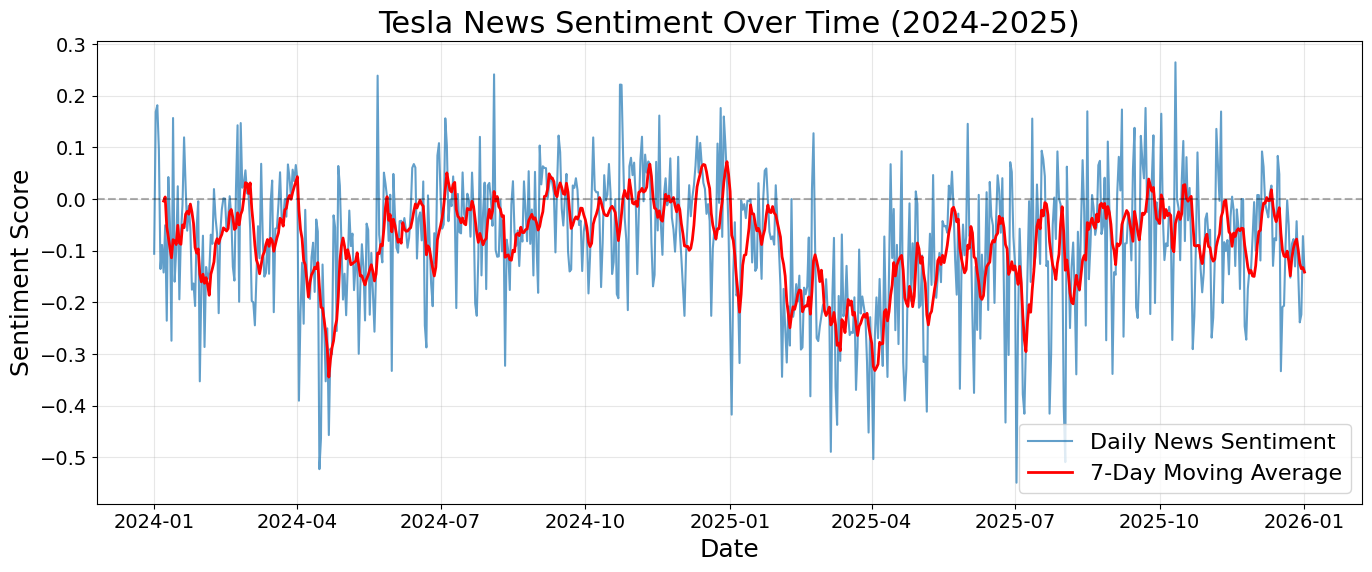

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 16,          # base font size
    'axes.titlesize': 22,     # title size
    'axes.labelsize': 18,     # x and y label size
    'xtick.labelsize': 14,    # x tick size
    'ytick.labelsize': 14,    # y tick size
    'legend.fontsize': 16     # legend size
})
# Load daily sentiment
daily_sent = pd.read_csv("daily_news_sentiment.csv")
daily_sent['date'] = pd.to_datetime(daily_sent['date'])

# Plot daily news sentiment
plt.figure(figsize=(14, 6))
plt.plot(daily_sent['date'], daily_sent['avg_sentiment'],
         alpha=0.7, label='Daily News Sentiment')

# Add 7-day moving average (smooth out noise)
daily_sent['sentiment_ma7'] = daily_sent['avg_sentiment'].rolling(7).mean()
plt.plot(daily_sent['date'], daily_sent['sentiment_ma7'],
         color='red', linewidth=2, label='7-Day Moving Average')

# Add horizontal line at 0 (neutral)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Tesla News Sentiment Over Time (2024-2025)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('output_plots/news_sentiment_trend.png', dpi=300)
plt.show()

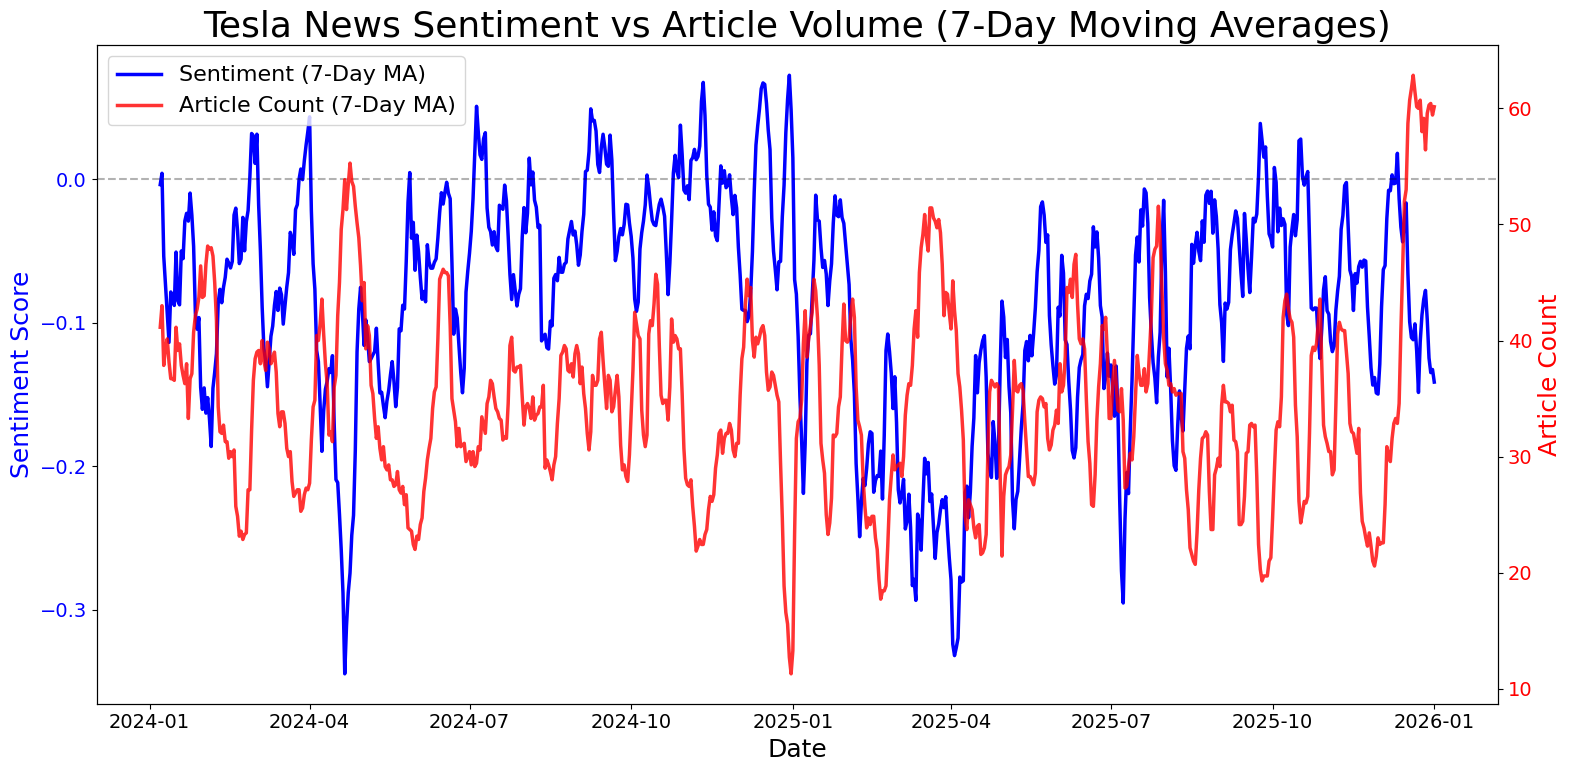

In [5]:
import matplotlib.pyplot as plt

daily_sent = pd.read_csv("data_storage/daily_news_sentiment.csv")
# Convert to datetime and sort
daily_sent['date'] = pd.to_datetime(daily_sent['date'])
daily_sent = daily_sent.sort_values('date')

plt.rcParams.update({
    'font.size': 16,          # base font size
    'axes.titlesize': 22,     # title size
    'axes.labelsize': 18,     # x and y label size
    'xtick.labelsize': 14,    # x tick size
    'ytick.labelsize': 14,    # y tick size
    'legend.fontsize': 16     # legend size
})
# Create moving averages
daily_sent['sentiment_ma7'] = daily_sent['avg_sentiment'].rolling(7).mean()
daily_sent['article_count_ma7'] = daily_sent['article_count'].rolling(7).mean()

fig, ax1 = plt.subplots(figsize=(16, 8))

# -----------------------------
# Sentiment (BLUE)
# -----------------------------
line1, = ax1.plot(
    daily_sent['date'],
    daily_sent['sentiment_ma7'],
    color='blue',
    linewidth=2.5,
    label='Sentiment (7-Day MA)'
)

ax1.axhline(0, color='black', linestyle='--', alpha=0.3)
ax1.set_xlabel('Date', fontsize=18)
ax1.set_ylabel('Sentiment Score', fontsize=18, color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# -----------------------------
# Article Count (RED, Smoothed)
# -----------------------------
ax2 = ax1.twinx()

line2, = ax2.plot(
    daily_sent['date'],
    daily_sent['article_count_ma7'],
    color='red',
    linewidth=2.5,
    alpha=0.8,
    label='Article Count (7-Day MA)'
)

ax2.set_ylabel('Article Count', fontsize=18, color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)

# -----------------------------
# Title & Legend
# -----------------------------
plt.title('Tesla News Sentiment vs Article Volume (7-Day Moving Averages)', fontsize=26)

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=16, loc='upper left')

plt.tight_layout()

plt.savefig('output_plots/news_sentiment_vs_article_volume.png', dpi=300)
plt.show()


Above we compared the number of articles averaged over the last 7 day period against the average sentiment score over the last 7 day period.  It looks like higher article counts might correlate with lower sentiment.  Let's see if that's the case.

We will begin with checking correlation against the 2 variables, and then shift the article count back a day to compare against the lagged information.

In [ ]:
daily_sent[['sentiment_ma7', 'article_count_ma7']].corr()

,sentiment_ma7,article_count_ma7
sentiment_ma7,1.000000,-0.258862
article_count_ma7,-0.258862,1.000000


Let's also do a scatter plot to see what this looks like.

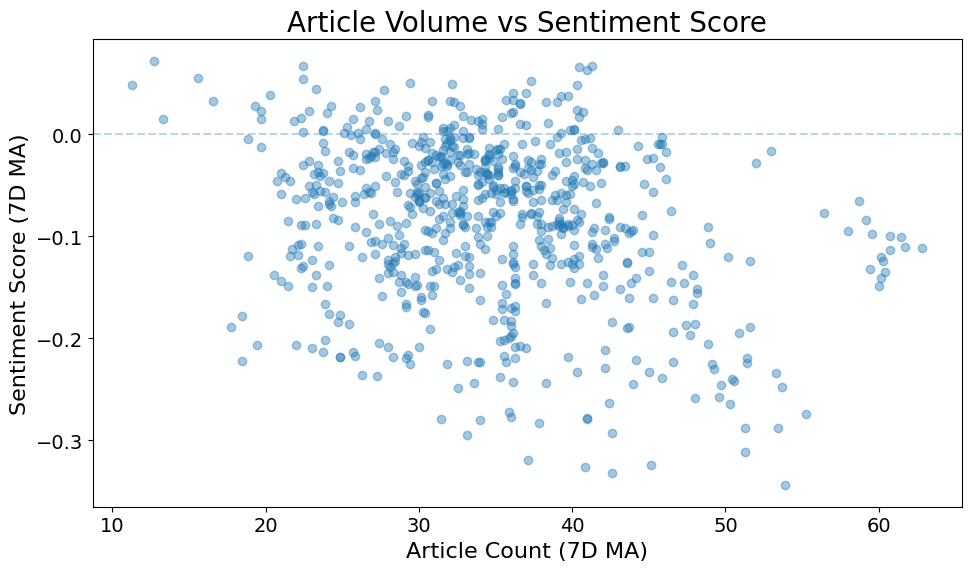

In [ ]:

plt.figure(figsize=(10,6))
plt.scatter(
    daily_sent['article_count_ma7'],
    daily_sent['sentiment_ma7'],
    alpha=0.4
)

plt.axhline(0, linestyle='--', alpha=0.3)
plt.xlabel('Article Count (7D MA)', fontsize=16)
plt.ylabel('Sentiment Score (7D MA)', fontsize=16)
plt.title('Article Volume vs Sentiment Score', fontsize=20)
plt.tight_layout()
plt.savefig('output_plots/news_sentiment_vs_article_volume_scatter.png', dpi=300)
plt.show()


In [ ]:
daily_sent['volume_lead1'] = daily_sent['article_count_ma7'].shift(1)

daily_sent[['sentiment_ma7', 'volume_lead1']].corr()

,sentiment_ma7,volume_lead1
sentiment_ma7,1.000000,-0.259084
volume_lead1,-0.259084,1.000000


There is a negative correlation between these variables of around -0.25, but let's investigate this further.

Rather than just compare the 2 variables in this way, let's check for when the article count is particularly high.  We will use the median of the data as that threshold.

In [ ]:
threshold = daily_sent['article_count_ma7'].median()

high_volume = daily_sent[daily_sent['article_count_ma7'] > threshold]
low_volume = daily_sent[daily_sent['article_count_ma7'] <= threshold]

print("Avg Sentiment (High Volume):", high_volume['sentiment_ma7'].mean())
print("Avg Sentiment (Low Volume):", low_volume['sentiment_ma7'].mean())
print("Diff High Vol vs. Low Vol:", high_volume['sentiment_ma7'].mean() - low_volume['sentiment_ma7'].mean())


Avg Sentiment (High Volume): -0.09699850980603908
Avg Sentiment (Low Volume): -0.07112874473238352
Diff High Vol vs. Low Vol: -0.025869765073655557


We found:

High volume avg sentiment: −0.097
Low volume avg sentiment: −0.071

So high-volume periods are indeed more negative, but the difference is approximately −0.026.

But is this different meaningful, let's perform a quick AB test to see.

In [ ]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    high_volume['sentiment_ma7'],
    low_volume['sentiment_ma7'],
    equal_var=False
)

print("t-stat:", t_stat)
print("p-value:", p_value)

t-stat: -4.492560968114821
p-value: 8.22517861605357e-06


t-stat: −4.49 -> negative direction (high-volume days have lower sentiment than low-volume days)

p-value: 8.2e-6 -> extremely small, essentially 0

This means:

The difference in average sentiment between high-volume and low-volume days is statistically highly significant.

Even though the absolute difference is modest (−0.097 vs −0.071), this confirms that it is unlikely to be due to random chance.

This shows:
1. High-volume days consistently have slightly more negative sentiment than low-volume days.
2. The effect is small in magnitude but reliably observed, which can matter in a stock-prediction context.
3. This is consistent with what I saw visually: spikes in article counts lining up with modest dips in sentiment.

Moving on from this, I also want to check if there is a correlation with change in sentiment score on the moving average.

In [ ]:
# Change in smoothed sentiment
daily_sent['sentiment_change'] = daily_sent['sentiment_ma7'].diff()

# Drop first NA
analysis_df = daily_sent.dropna(subset=['sentiment_change', 'article_count_ma7'])

print(analysis_df[['article_count_ma7', 'sentiment_change']].corr())


                   article_count_ma7  sentiment_change
article_count_ma7           1.000000         -0.072124
sentiment_change           -0.072124          1.000000


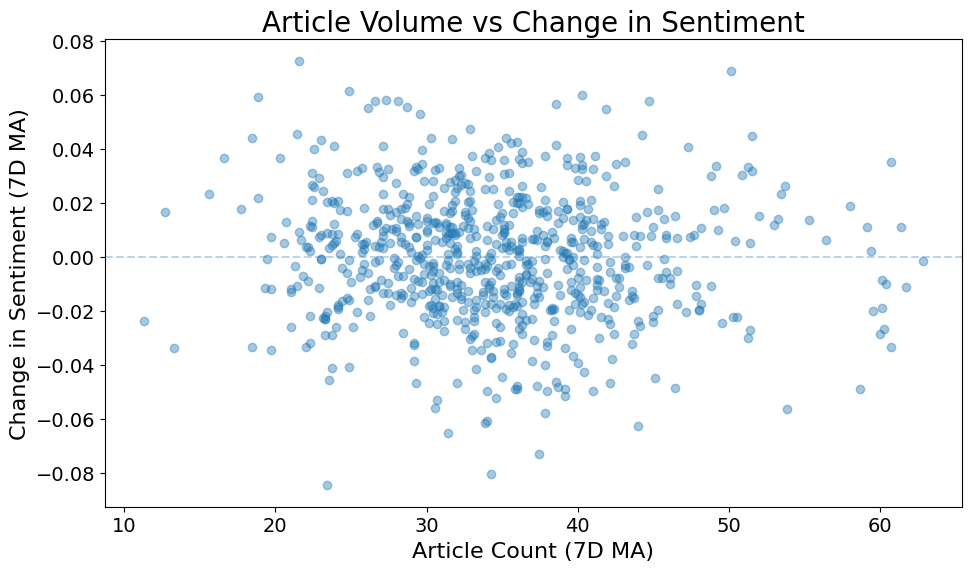

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(
    analysis_df['article_count_ma7'],
    analysis_df['sentiment_change'],
    alpha=0.4
)

plt.axhline(0, linestyle='--', alpha=0.3)
plt.xlabel('Article Count (7D MA)', fontsize=16)
plt.ylabel('Change in Sentiment (7D MA)', fontsize=16)
plt.title('Article Volume vs Change in Sentiment', fontsize=20)
plt.tight_layout()
plt.show()


In [ ]:
analysis_df['volume_lag1'] = analysis_df['article_count_ma7'].shift(1)

analysis_df[['volume_lag1', 'sentiment_change']].corr()


,volume_lag1,sentiment_change
volume_lag1,1.000000,-0.005221
sentiment_change,-0.005221,1.000000


At least with the moving average, there is nothing here to make me think there is a substantial correlation between the change in sentiment (from previous day) and article count.

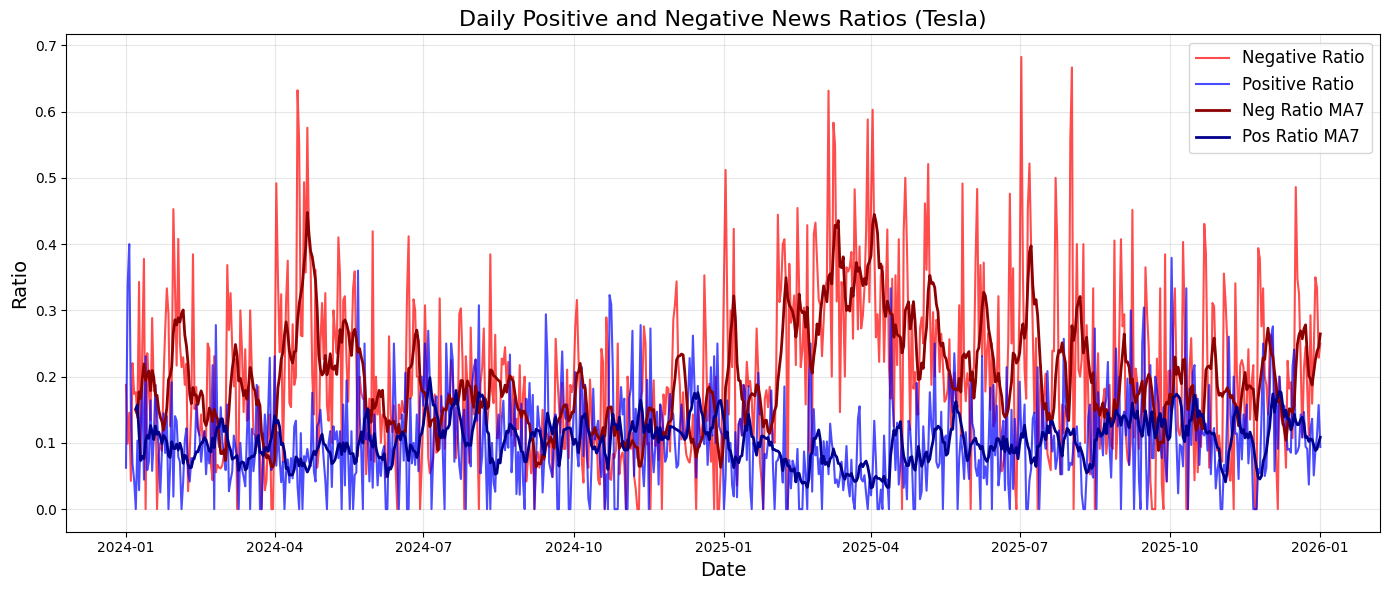

In [ ]:
import matplotlib.pyplot as plt
# Load daily sentiment
daily_sent = pd.read_csv("data_storage/daily_news_sentiment.csv")
daily_sent['date'] = pd.to_datetime(daily_sent['date'])

plt.figure(figsize=(14, 6))

# Plot negative and positive ratios
plt.plot(daily_sent['date'], daily_sent['neg_ratio'], color='red', alpha=0.7, label='Negative Ratio')
plt.plot(daily_sent['date'], daily_sent['pos_ratio'], color='blue', alpha=0.7, label='Positive Ratio')

# 7-day moving averages
daily_sent['neg_ratio_ma7'] = daily_sent['neg_ratio'].rolling(7).mean()
daily_sent['pos_ratio_ma7'] = daily_sent['pos_ratio'].rolling(7).mean()
plt.plot(daily_sent['date'], daily_sent['neg_ratio_ma7'], color='darkred', linewidth=2, label='Neg Ratio MA7')
plt.plot(daily_sent['date'], daily_sent['pos_ratio_ma7'], color='darkblue', linewidth=2, label='Pos Ratio MA7')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Ratio', fontsize=14)
plt.title('Daily Positive and Negative News Ratios (Tesla)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('output_plots/daily_pos_vs_neg_articles.png', dpi=300)
plt.show()


Based on our analysis, I want to use the following variables for our predictive model.  Both using 7-day smoothed averages as well as the daily values.  Then also using a lagged value of each of them.  And I want to look at the interactive multiplicative term between the sentiment and the article count.  This will allow for the model to adjust for when the sentiment is high or low in relation to the article count.

-avg_sentiment: daily news sentiment

-avg_sentiment_ma7: 7-day smoothed news sentiment (captures trend-level sentiment)

-article_count: daily number of news articles

-article_count_ma7: 7-day smoothed article count (captures trend-level coverage)

-interaction: daily interaction between sentiment and volume (avg_sentiment * article_count)

-interaction_ma7: interaction between smoothed sentiment and smoothed volume (avg_sentiment_ma7 * article_count_ma7)

-avg_sentiment_lag1: yesterday’s daily sentiment

-article_count_lag1: yesterday’s daily article count

-interaction_lag1: yesterday’s daily interaction (avg_sentiment_lag1 * article_count_lag1)

-last_earnings_sentiment: sentiment score from the most recent earnings call

In [ ]:
import pandas as pd

# -----------------------------
# Load all data at the top
# -----------------------------
daily_sent = pd.read_csv("daily_news_sentiment.csv")
earnings_df = pd.read_csv("earnings_sentiment.csv")

# Ensure 'date' columns are datetime
daily_sent['date'] = pd.to_datetime(daily_sent['date'])
earnings_df['call_date'] = pd.to_datetime(earnings_df['call_date'])

# Sort earnings by call date
earnings_df = earnings_df.sort_values('call_date')

# -----------------------------
# Core daily variables
# -----------------------------
daily_sent['avg_sentiment'] = daily_sent['avg_sentiment']        # daily news sentiment
daily_sent['article_count'] = daily_sent['article_count']        # daily number of news articles

# -----------------------------
# 7-day moving averages
# -----------------------------
daily_sent['avg_sentiment_ma7'] = daily_sent['avg_sentiment'].rolling(7).mean()
daily_sent['article_count_ma7'] = daily_sent['article_count'].rolling(7).mean()

# -----------------------------
# Lagged variables (yesterday's values)
# -----------------------------
daily_sent['avg_sentiment_lag1'] = daily_sent['avg_sentiment'].shift(1)
daily_sent['article_count_lag1'] = daily_sent['article_count'].shift(1)

# -----------------------------
# Interaction terms
# -----------------------------
# Initially, I didn't want to calculate these until we split train and testing to avoid data leakage
# but to make the results more interpretable, I decided to do so anyways (later) in the next coding
# file.  This stays commented out because I create these features later.
# daily_sent['interaction'] = daily_sent['avg_sentiment'] * daily_sent['article_count']
# daily_sent['interaction_ma7'] = daily_sent['avg_sentiment_ma7'] * daily_sent['article_count_ma7']

# -----------------------------
# Latest earnings call sentiment
# -----------------------------
# Use merge_asof to assign the most recent earnings call score
daily_sent = pd.merge_asof(
    daily_sent,
    earnings_df[['call_date', 'avg_sentiment']].rename(columns={'avg_sentiment': 'latest_earnings_sentiment'}),
    left_on='date',
    right_on='call_date',
    direction='backward'
)

# -----------------------------
# Features to save
# -----------------------------
features_to_save = [
    'date',
    'avg_sentiment',
    'avg_sentiment_ma7',
    'article_count',
    'article_count_ma7',
    'avg_sentiment_lag1',
    'article_count_lag1',
    'latest_earnings_sentiment'
]

# -----------------------------
# Select only relevant columns and drop NA
# -----------------------------
daily_sent_features = daily_sent[features_to_save].dropna()

# -----------------------------
# Save to CSV
# -----------------------------
daily_sent_features.to_csv("data_storage/daily_sent_features.csv", index=False)

# Preview
print(daily_sent_features.head(10))


         date  avg_sentiment  avg_sentiment_ma7  article_count  \
23 2024-01-24      -0.057471          -0.009703             76   
24 2024-01-25      -0.175297          -0.025078             59   
25 2024-01-26      -0.163414          -0.046786             57   
26 2024-01-27      -0.206962          -0.093412             17   
27 2024-01-28      -0.054269          -0.104522             16   
28 2024-01-29      -0.004313          -0.096411             47   
29 2024-01-30      -0.352734          -0.144923             53   
30 2024-01-31      -0.165098          -0.160298             57   
31 2024-02-01      -0.070861          -0.145379             60   
32 2024-02-02      -0.286277          -0.162931             76   

    article_count_ma7  avg_sentiment_lag1  article_count_lag1  \
23          36.714286           -0.013149                34.0   
24          37.142857           -0.057471                76.0   
25          40.714286           -0.175297                59.0   
26          4

In [ ]:
earnings_df.sort_values(by=['call_date'])

,filename,call_date,avg_sentiment,neg_ratio,pos_ratio,num_chunks
7,TSLA_Q4_2023_Earnings_Call_Transcript.rtf,2024-01-24,0.077734,0.035461,0.134752,141
5,TSLA_Q1_2024_Earnings_Call_Transcript.rtf,2024-04-23,0.033616,0.054054,0.101351,148
4,TSLA_Q2_2024_Earnings_Call_Transcript.rtf,2024-07-24,0.099173,0.024793,0.148760,121
3,TSLA_Q3_2024_Earnings_Call_Transcript.rtf,2024-10-23,0.077639,0.029197,0.138686,137
2,TSLA_Q4_2024_Earnings_Call_Transcript.rtf,2025-01-29,0.019609,0.045455,0.068182,132
8,TSLA_Q1_2025_Earnings_Call_Transcript.rtf,2025-04-22,0.060126,0.032258,0.116129,155
1,TSLA_Q2_2025_Earnings_Call_Transcript.rtf,2025-07-23,0.232913,0.053571,0.330357,112
0,TSLA_Q3_2025_Earnings_Call_Transcript.rtf,2025-10-22,0.175250,0.033333,0.250000,120
6,TSLA_Q4_2025_Earnings_Call_Transcript.rtf,2026-01-28,0.103768,0.059322,0.186441,118
